In [ ]:
# Importing the packages
import pandas as pd
import numpy as np
import seaborn as sns

In [ ]:
#Loading the data
df=pd.read_csv('taxifare.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.3+ MB


## Feature Engineering

In [ ]:
import datetime

In [ ]:
# UTC time is 4 hours ahead of NYC time
df['pickup_datetime'] =pd.to_datetime(df['pickup_datetime']) - datetime.timedelta(hours=4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(2)
memory usage: 7.3 MB


In [ ]:
df['Year']=df['pickup_datetime'].dt.year
df['Month']= df['pickup_datetime'].dt.month
df['Day']=df['pickup_datetime'].dt.day
df['Hour']=df['pickup_datetime'].dt.hour
df['Minutes']=df['pickup_datetime'].dt.minute

In [ ]:
# Derving part of day 0 means its AM and 1 means its PM
df['part_of_day'] =np.where(df['Hour']<12,0,1)

In [ ]:
df.drop(['pickup_datetime'], axis=1, inplace=True)

# Calculating the Haversine Distance for pickup and dropoff locations


In [ ]:
def haversine(dataframe):
    latitude1= np.radians(df["pickup_latitude"])
    latitude2= np.radians(df['dropoff_latitude'])
    difference_latitude= np.radians(df['dropoff_latitude']-df['pickup_latitude'])
    difference_longitude= np.radians(df['dropoff_longitude'] - df['pickup_longitude'])
    a = np.sin(difference_latitude/2)**2 + np.cos(latitude1) * np.cos(latitude2)*np.sin(difference_longitude/2)**2
    b = 2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    c= 6371
    return c*b

In [ ]:
# Total distance travelled by customer in the taxi
df['Distance_Travelled'] =haversine(df)
#Converting Kilometers to Miles
df['Distance_Travelled'] = df['Distance_Travelled'] /1.6103

In [ ]:
df.drop(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude','dropoff_latitude'], axis=1, inplace=True)

# Artificial Neural Networks

In [ ]:
x=df.iloc[:,0:-1]
y=df.iloc[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.2,random_state=5)

In [ ]:

# Part 2 - Now let's make the ANN!

# Importing the Keras libraries and packages
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU,PReLU,ELU
from tensorflow.keras.layers import Dropout

In [ ]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = x_train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

# Fitting the ANN to the Training set
model_history=NN_model.fit(x_train, y_train,validation_split=0.33, batch_size = 10, epochs = 20)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 166145 (649.00 KB)
Trainable params: 166145 (649.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
1608/

## Model Evaluation

In [ ]:
predict=NN_model.predict(x_test)

3000/3000 [==============================] - 7s 2ms/step


<ipython-input-19-3220d5c20fd9>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test.values.reshape(-1,1)-predict)


<Axes: ylabel='Density'>

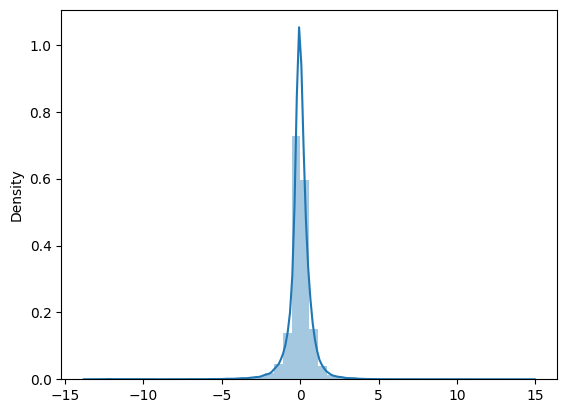

In [ ]:
import seaborn as sns
sns.distplot(y_test.values.reshape(-1,1)-predict)

In [ ]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, predict))
print('MSE:', metrics.mean_squared_error(y_test, predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predict)))

MAE: 0.48837546507768986
MSE: 0.8948827394221512
RMSE: 0.9459824202500547


In [36]:
import pickle
pickle.dump(NN_model,open("best_neural_model.pkl",'wb'))

#### TPOTRegressor Automated Library

In [ ]:
from tpot import TPOTRegressor

In [ ]:
tpot = TPOTRegressor(generations=1, population_size=10, verbosity=2, random_state=42)
tpot.fit(x_train, y_train)
print(tpot.score(x_test, y_test))
tpot.export('tpot_taxiFaredocumentation_pipeline.py')

Optimization Progress:   0%|          | 0/20 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.7840871322242121

Best pipeline: RandomForestRegressor(input_matrix, bootstrap=True, max_features=0.7500000000000001, min_samples_leaf=11, min_samples_split=9, n_estimators=100)
-0.8007523233719758


In [27]:
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive

# NOTE: Make sure that the outcome column is labeled 'target' in the data file
tpot_data = pd.read_csv('preprocessed_taxifare.csv', sep=',', dtype=np.float64)
features = tpot_data.drop('fare_amount', axis=1)
train_features, test_features, train_target, test_target = train_test_split(features, tpot_data['fare_amount'], random_state=42)

In [30]:

# Define the pipeline
exported_pipeline = make_pipeline(
    RandomForestRegressor(bootstrap=True, max_features=0.75,
                          min_samples_leaf=11, min_samples_split=9,
                          n_estimators=100, random_state=42)
)

# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(train_features, train_target)

# Predict the results
results = exported_pipeline.predict(test_features)

<ipython-input-31-e9a9dae0500d>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(test_target.values-results)


<Axes: ylabel='Density'>

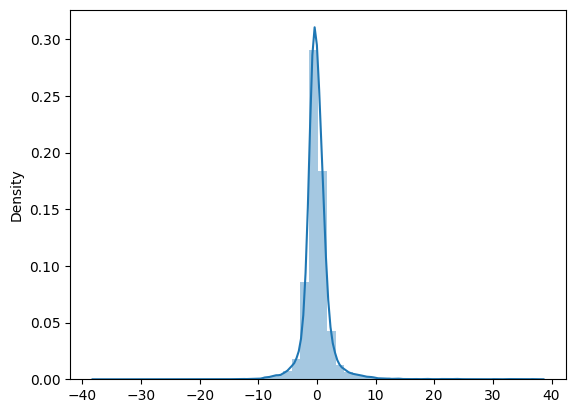

In [31]:
import seaborn as sns
sns.distplot(test_target.values-results)

In [33]:

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(test_target, results))
print('MSE:', metrics.mean_squared_error(test_target, results))
print('RMSE:', np.sqrt(metrics.mean_squared_error(test_target, results)))

MAE: 1.4053686359660216
MSE: 6.336562996055803
RMSE: 2.5172530655569383
